# 定义问题

It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

预测房价
With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

# 获取数据

Kaggle:https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

# 数据预处理

## 导入环境库

In [1]:
#load packages， 打印，便于可复现
import sys #access to system parameters https://docs.python.org/3/library/sys.html
print("Python version: {}". format(sys.version))

import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
print("pandas version: {}". format(pd.__version__))

import matplotlib #collection of functions for scientific and publication-ready visualization
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np #foundational package for scientific computing
print("NumPy version: {}". format(np.__version__))

import scipy as sp #collection of functions for scientific computing and advance mathematics
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
print("IPython version: {}". format(IPython.__version__)) 

import sklearn #collection of machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))

#misc libraries
import random
import time


#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)



Python version: 2.7.13 |Anaconda custom (x86_64)| (default, Dec 20 2016, 23:05:08) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
pandas version: 0.23.3
matplotlib version: 2.0.0
NumPy version: 1.12.1
SciPy version: 1.1.0
IPython version: 5.1.0
scikit-learn version: 0.19.1
-------------------------


## 导入数据模型与可视化库

In [2]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

## 载入总览数据

In [77]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

'''
预测SalePrice的值
'''

# train_df.columns 
# train_df.shape
train_df.describe()
# train_df.info()
# print '%' * 40
# test_df.info()
# train_df.head(10)
# train_df.info()
# print train_df.describe(include = 'all')
# print '%' * 40
# test_df.info()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## 4C分析

数据的：

正确性：Reviewing the data, there does not appear to be any aberrant or non-acceptable data inputs.异常值

完整性：NULL / NAN。删除/补全

创造性：Feature engineering is when we use existing features to create new features to determine if they provide new signals to predict our outcome. For this dataset, we will create a title feature to determine if it played a role in survival.

转变：类别数据 -> 独热编码

### 完整性 (缺失值)

https://discuss.analyticsvidhya.com/t/what-should-be-the-allowed-percentage-of-missing-values/2456

I：允许的missing values的数目，先定25%

In [4]:
# # Missing Data的百分比
# total = train_df.isnull().sum().sort_values(ascending=False)
# percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
# missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# # print missing_data.head(20)

# total2 = test_df.isnull().sum().sort_values(ascending=False)
# percent2 = (test_df.isnull().sum()/test_df.isnull().count()).sort_values(ascending=False)
# missing_data2 = pd.concat([total2, percent2], axis=1, keys=['Total', 'Percent'])
# # print missing_data2.head(20)

In [5]:
train_df.describe(include = 'all')
print '%' * 40

# print train_df.loc[:,'MasVnrType']

# train_df['MasVnrType'] = train_df['MasVnrType'].replace(['None'],None )
# train_df.loc[:,'MasVnrType'] =  train_df['MasVnrType'].apply(lambda x: None if x == 'None' else x)
# print type(train_df.loc[1,'MasVnrType'])

limit_missing_values = 0.25
train_limit_missing_values = len(train_df) * limit_missing_values 
print "Train columns with null values:\n", train_df.columns[train_df.isnull().sum().values > train_limit_missing_values]  # 依列为标准，column
print '%'*40

test_limit_missing_values = len(test_df) * limit_missing_values
print "Test columns with null values:\n", test_df.columns[test_df.isnull().sum().values > test_limit_missing_values]



%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Train columns with null values:
Index([u'Alley', u'FireplaceQu', u'PoolQC', u'Fence', u'MiscFeature'], dtype='object')
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Test columns with null values:
Index([u'Alley', u'FireplaceQu', u'PoolQC', u'Fence', u'MiscFeature'], dtype='object')


❌ 丢弃过多空数据的列

部分类别数据中的NA非未计数/计数误差，而是无（地下室，游泳池🏊等，填充字符串“None”）

In [6]:
# drop_columns = ['Alley', u'FireplaceQu', u'PoolQC', u'Fence', u'MiscFeature']
# train_df = train_df.drop(drop_columns, axis=1)
# test_df = test_df.drop(drop_columns, axis=1)

# # train_df = train_df.drop(missing_data[missing_data['Total'] > 1].index, axis=1)
# # train_df = train_df.drop(train_df.loc[train_df['Electrical'].isnull()].index)
# train_df.isnull().sum().max()

# # test_df = test_df.drop(missing_data[missing_data['Total'] > 1].index, axis=1)
# test_df.isnull().sum().max()


In [7]:
# train_df.columns

II:特征意义

特征意义：

0、ID 无意义，去掉

1、MSSubClass 住所风格

2、MSZoing 地带

3、LotFrontage 住宅到街道的步行距离

4、LotArea 地块面积

5、。。

III: 填充空数据

数值：中位数

类别：众数

In [8]:
missing_columns = list(train_df.columns[train_df.isnull().sum() != 0])
print (missing_columns)
# train_df[missing_columns].describe(include = 'all')
print '%' * 40
test_missing_columns = list(test_df.columns[test_df.isnull().sum() != 0])
print test_missing_columns

['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']


In [9]:
# combine = [train_df, test_df]
train_missing_columns_nums = ['LotFrontage', 'MasVnrArea','GarageYrBlt']
train_categories = [x for x in missing_columns if x not in train_missing_columns_nums]

# train_missing_columns_categories = ['MasVnrType', 'BsmtQual','BsmtCond', 
#                               'BsmtExposure','BsmtFinType1','BsmtFinType2', 
#                               'Electrical', 'GarageType', 'GarageFinish',
#                               'GarageQual','GarageCond']

condition = test_df[test_missing_columns].describe(include='all').loc['mean'].isnull()

test_missing_columns_categories = test_df[test_missing_columns].describe(include='all').loc['mean'].loc[condition].index
test_missing_columns_nums = [x for x in test_missing_columns if x not in test_missing_columns_categories]

# for data in combine:
    
#     # 通过中位数填充 median()
#     for column in missing_columns_nums:
#         data[column].fillna(data[column].median(), inplace= True)

print train_categories, '\n'
print test_missing_columns_categories, '\n'


['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'] 

Index([u'MSZoning', u'Alley', u'Utilities', u'Exterior1st', u'Exterior2nd',
       u'MasVnrType', u'BsmtQual', u'BsmtCond', u'BsmtExposure',
       u'BsmtFinType1', u'BsmtFinType2', u'KitchenQual', u'Functional',
       u'FireplaceQu', u'GarageType', u'GarageFinish', u'GarageQual',
       u'GarageCond', u'PoolQC', u'Fence', u'MiscFeature', u'SaleType'],
      dtype='object') 



### 类别特征缺失值划分

In [10]:
# 取众数的特征
train_categories_Mode = ['Electrical']
test_categories_Mode = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Functional', 'SaleType']

train_categories_none = [i for i in train_categories if i not in train_categories_Mode]
test_categories_none = [i for i in test_missing_columns_categories if i not in test_categories_Mode]


In [11]:
# 取0的数值特征

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    train_df[col] = train_df[col].fillna(0)
    test_df[col] = test_df[col].fillna(0)
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    train_df[col] = train_df[col].fillna(0)
    test_df[col] = test_df[col].fillna(0)

In [12]:
# 通过中位数填充
for column in train_missing_columns_nums:
    train_df[column].fillna(train_df[column].median(), inplace=True)

for column in test_missing_columns_nums:
    test_df[column].fillna(test_df[column].median(), inplace=True)
    
    
# ❌通过最大类填充，众数 
# ✅通过字符串“None”填充 | 区分 众数
for category in train_categories_none:
    train_df[category].fillna("None", inplace=True)
    
for category in test_categories_none:
    test_df[category].fillna("None", inplace=True)
    
for category in train_categories_Mode:
    train_df[category].fillna(train_df[category].mode()[0], inplace = True)

for category in test_categories_Mode:
    test_df[category].fillna(test_df[category].mode()[0], inplace = True)

In [13]:
print train_df.isnull().sum().max()
print test_df.isnull().sum().max()
# print test_df.loc[test_df.isnull()

0
0


# 探索性数据分析 EDA

感谢： https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python 提出的对数据进行探索的方法

### 目标

1、In order to have some discipline in our analysis, we can create an Excel spreadsheet with the following columns:

* <b>Variable</b> - Variable name.
* <b>Type</b> -  There are two possible values for this field: 'numerical' or 'categorical'. 
* <b>Segment</b> - Identification of the variables' segment. We can define three possible segments: building, space or location. When we say 'building', we mean a variable that relates to the physical characteristics of the building (e.g. 'OverallQual'). When we say 'space', we mean a variable that reports space properties of the house (e.g. 'TotalBsmtSF'). Finally, when we say a 'location', we mean a variable that gives information about the place where the house is located (e.g. 'Neighborhood').
* <b>Expectation</b> - Our expectation about the variable influence in 'SalePrice'. We can use a categorical scale with 'High', 'Medium' and 'Low' as possible values.
    
    重要，一一个一个阅读特征描述。是否影响我们购买房屋 -> 如果是，影响重要性？ -> 信息是否早已在其他变量中包含
* <b>Conclusion</b> - Our conclusions about the importance of the variable, after we give a quick look at the data. We can keep with the same categorical scale as in 'Expectation'.
* <b>Comments</b> - Any general comments that occured to us.


2、we can filter the spreadsheet and look carefully to the variables with 'High' 'Expectation'. Then, we can rush into some scatter plots between those variables and 'SalePrice', filling in the 'Conclusion' column which is just the correction of our expectations.

### 目标数据的【身材】 SalePrice （单变量分布）

*Everything started in our Kaggle party, when we were looking for a dance partner. After a while searching in the dance floor, we saw a girl, near the bar, using dance shoes. That's a sign that she's there to dance. We spend much time doing predictive modelling and participating in analytics competitions, so talking with girls is not one of our super powers. Even so, we gave it a try:*

*'Hi, I'm Kaggly! And you? 'SalePrice'? What a beautiful name! You know 'SalePrice', could you give me some data about you? I just developed a model to calculate the probability of a successful relationship between two people. I'd like to apply it to us!'*

In [14]:
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

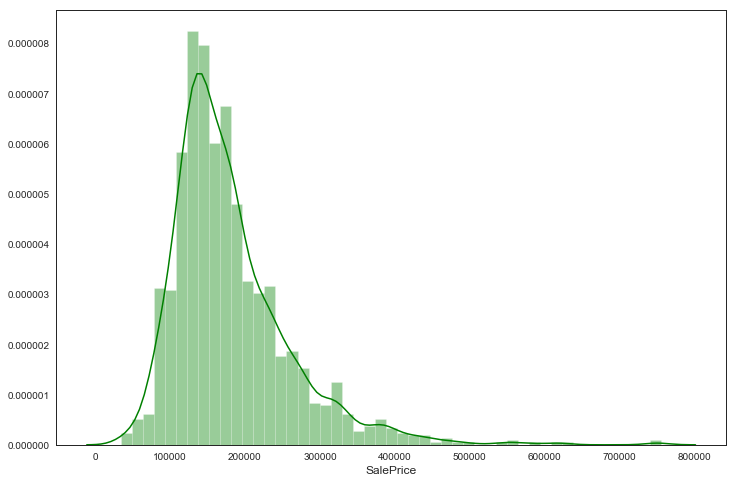

In [15]:
sns.distplot(train_df['SalePrice'], color='green')

* <b> 正偏态分布 </b> 数据主要集中在10w ~ 25w之间

In [16]:
print "偏度为 %f " % train_df['SalePrice'].skew()
print "峰度为 %f"  % train_df['SalePrice'].kurt()

偏度为 1.882876 
峰度为 6.536282


### 目标数据的Buddies and interests  （两个变量之间的关系）

As soon as 'SalePrice' walked away, we went to Facebook. Yes, now this is getting serious. Notice that this is not stalking. It's just an intense research of an individual, if you know what I mean.

According to her profile, we have some common friends. Besides Chuck Norris, we both know 'GrLivArea' and 'TotalBsmtSF'. Moreover, we also have common interests such as 'OverallQual' and 'YearBuilt'. This looks promising!

To take the most out of our research, we will start by looking carefully at the profiles of our common friends and later we will focus on our common interests.

#### 同数值变量之间的关系 (散点图）

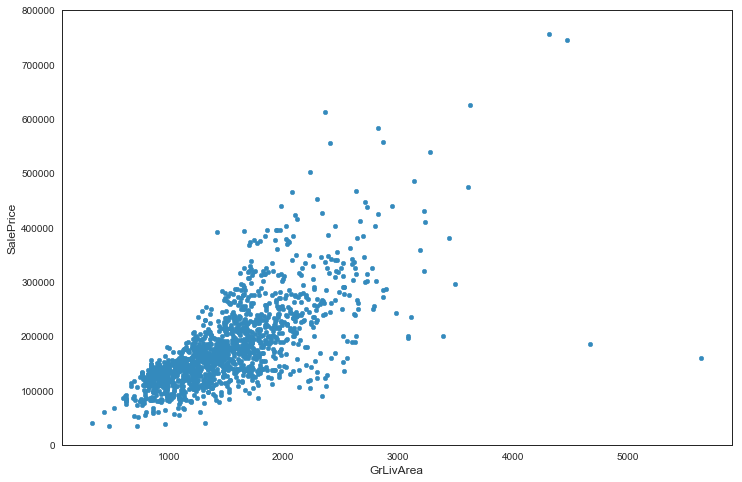

In [17]:
var = 'GrLivArea' # 房屋居住面积

# concat - Series默认行合并； axis = 1，列合并
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1) 
# print dataFrame
data.plot.scatter(x=var, y='SalePrice', ylim = (0, 800000)) # y轴限制

房屋价格同居住面积（平方英尺）线性相关

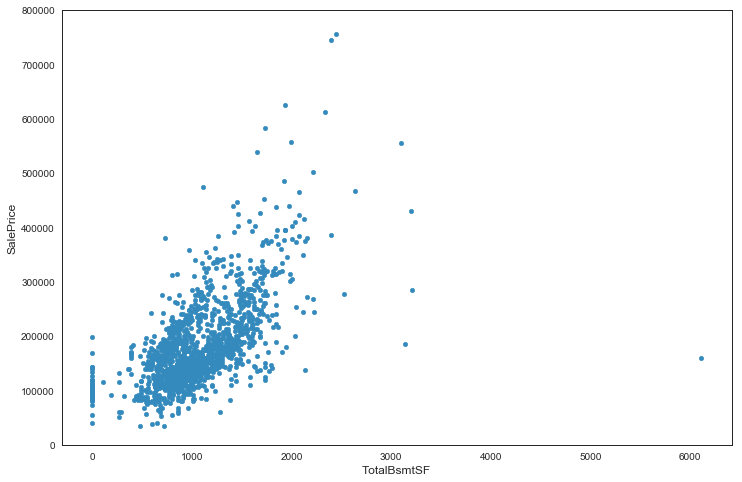

In [18]:
var = 'TotalBsmtSF'  # 房屋地下室的面积
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
data.plot.scatter(x = var, y = 'SalePrice', ylim = (0, 800000))

房屋价格同地下室的面积成强线性（指数？）相关

存在一些无地下室的房屋，房屋价格分布在200000以内

#### 同类别变量之间的关系 （箱型图）

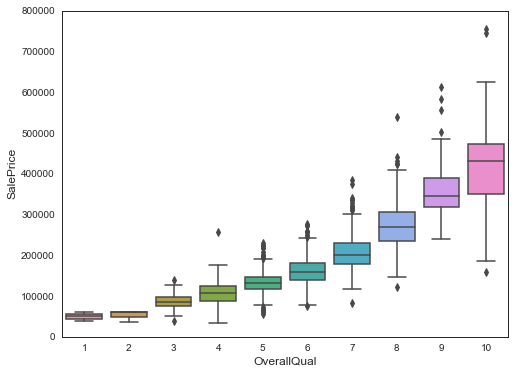

In [19]:
var = 'OverallQual'  # 房屋整体材料和光洁度的评估
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)  # 横坐标类别，纵坐标目标变量
fig.axis(ymin=0, ymax=800000);

房屋价格同房屋整体材料和光洁度的评估强相关，整体评估分数越高，房屋价格越高

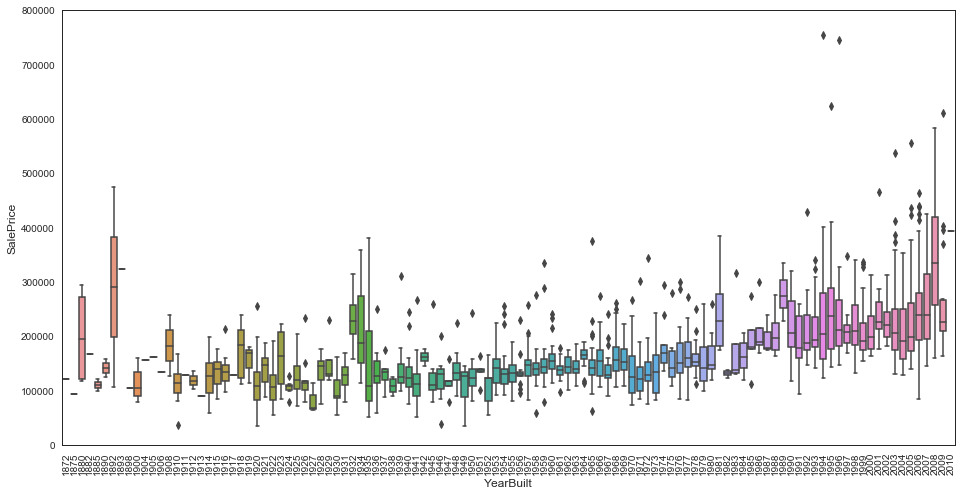

In [20]:
var = 'YearBuilt'  # 房屋建造年份
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))  # 改变大小
fig = sns.boxplot(x=var, y="SalePrice", data=data)  # 横坐标类别，纵坐标目标变量
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);               # x如果都水平放置，会粘到一起。x倾斜90度，减少占的位置

虽然斜率小，但是新房相对于老房来说房屋价格相对较高

#### 总结

1、房屋居住面积和房屋地下室的面积同房屋价格呈正相关

2、房屋整体材料质量和建造年份同房屋价格相关。其中房屋整体材料质量同房屋价格相关性更强

以上：特征选择，主观性

The trick here seems to be the choice of the right features (feature selection) and not the definition of complex relationships between them (feature engineering).

That said, let's separate the wheat from the chaff.

以下：特征工程，客观性

### 客观分析

####  把一些数值特征转化为类别特征

In [21]:
#MSSubClass=The building class

cols = ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold', 'BedroomAbvGr']

for col in cols:
    train_df[col] = train_df[col].apply(str)
    test_df[col] = test_df[col].apply(str)

* <b>相关性矩阵</b>
* <b>房屋价格相关性矩阵</b>
* <b>最相关变量散点图</b>

#### 整体相关性矩阵

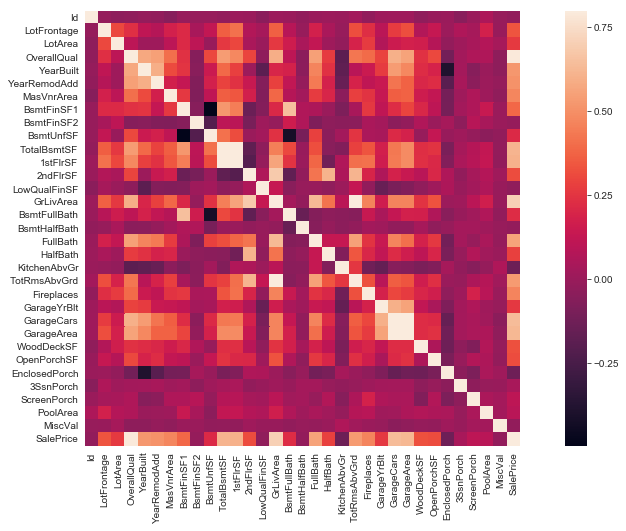

In [22]:
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(corrmat, vmax= .8, square=True);   # vmax 颜色区别，最浅的颜色在0.8

更加宏观

1、“TotalBsmtSF” 同 “1stFlrSF”强相关，表达同样的信息

2、“GarageCars”  同 “GarageArea”强相关，表达同样的信息

3、验证“SalePrice” 同主观选择的特征相关，仍有部分特征需加入"SalePrice"预测

#### 目标变量相关性矩阵 (SalePrice，放大热力图）

In [23]:
# help(corrmat.nlargest)

In [24]:
# # cols = corrmat.nlargest(k, 'SalePrice').index
# # print cols
# len (train_df[cols].values)  # 数组，1460 * 10 | 转置 10 * 1460

In [25]:
old_features = ['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF']
train_df['TotalSF'] = 0
test_df['TotalSF'] = 0
for i in old_features:
    print train_df['SalePrice'].corr(train_df[i])
    train_df['TotalSF'] += train_df[i]
    test_df['TotalSF'] += test_df[i]
train_df['SalePrice'].corr(train_df['TotalSF'])

0.605852184692
0.319333802832
0.613580551559


0.7822600527979845

In [26]:
train_df.drop(old_features, axis = 1, inplace=True)
test_df.drop(old_features, axis=1, inplace=True)

In [27]:
corrmat = train_df.corr()

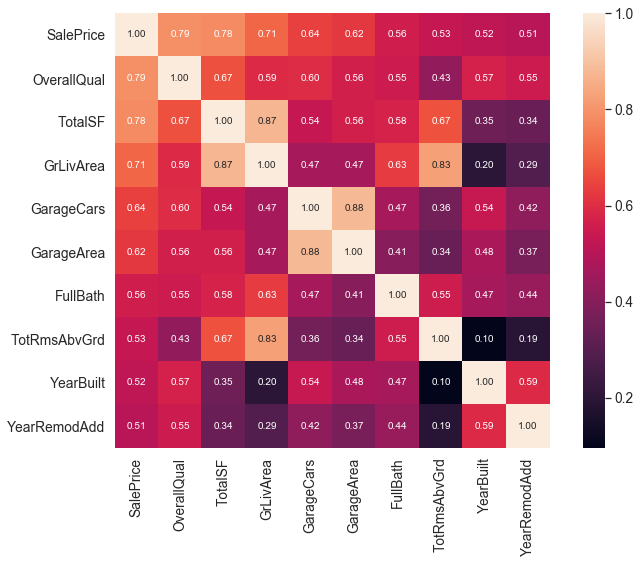

In [28]:
#saleprice correlation matrix
k = 10   #number of variables for heatmap，热力图变量数量 

# nlargest - 根据SalePrice列排序，返回前10个跟SalePrice相关性最高的行
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index 

# cm = corrmat.loc[cols,cols] 同以下cm赋值相同
# 训练集中取出目标列的样本，转置，计算10个特征之间的相关性
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [29]:
cols = ['SalePrice', 'OverallQual', 'TotalSF', 'GrLivArea', 'GarageCars', 'FullBath', 'YearBuilt']

In [30]:
# # # print train_df['FullBath'].value_counts().plot.bar()
# var = 'FullBath'  # 浴室的品质
# data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
# f, ax = plt.subplots(figsize=(8, 6))
# fig = sns.boxplot(x=var, y="SalePrice", data=data)  # 横坐标类别，纵坐标目标变量
# fig.axis(ymin=0, ymax=800000);

In [31]:
drop_columns = [i for i in corrmat.columns if i not in cols]

In [32]:
print drop_columns

['Id', 'LotFrontage', 'LotArea', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']




1、确认主观特征选择变量'OverallQual'，'GrLivArea' ，'TotalBsmtSF'同房屋价格强相关

2、因为“GarageCars” 同 “GarageArea”强相关，故选择同房屋价格相关性更高的“GarageCars”

3、同上，选择“TotalBasmtSF”

4、“TotRmsAbvGrd” 同“GrLivArea”强相关，选择“GrLivArea”

5、"YearBuilt"【待】时间序列分析

6、 "FullBath"浴室的品质，从箱型图中可以看出浴室的品质同房屋的价格呈正相关

    同时存在一些无浴室的房屋

#### 最相关变量散点图

In [33]:
# cols

In [34]:
# #scatterplot
# sns.set()
# cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
# sns.pairplot(train_df[cols], size = 2.5)
# plt.show();

### 正确性

去除异常值

1、TotalBsmtSF 为0 = 房屋中没有地下室，数据正常

2、故仅针对GrLivArea 做异常值去除

In [35]:
# olss = []
# numerical_features = ['GrLivArea']
# for feature in numerical_features:
    
#     # 计算25%分位点
#     Q1 = np.percentile(train_df[feature], 25)
    
#     # 计算75%分位点
#     Q3 = np.percentile(train_df[feature], 75)
#     print Q3
    
#     # 异常阶（1.5倍四分位距）IQR
#     step = 1.5 * (Q3 - Q1)
    
#     print "Feature" + feature + "Outlines"
#     print train_df[ (train_df[feature] <= Q1 - step) | (train_df[feature] >= Q3 + step)][numerical_features]
#     ols = features_train[ (train_df[feature] <= Q1 - step) | (train_df[feature] >= Q3 + step)].index.tolist()
#     olss.append(ols)
    
# olss_new = [ii for i in olss for ii in i]
# # print olss_new

# # 列表方法 .count(i) 统计列表中某个元素出现的次数
# more_than_one = list(set([i for i in olss_new if olss_new.count(i) > 1]))
# more_than_two = list(set([i for i in olss_new if olss_new.count(i) > 2]))
# print len(more_than_one), len(more_than_two)

# ## 移除异常点
# # features_train_new = features_train.drop(features_train.index[olss_new]).reset_index(drop = True)
# # labels_train_new = labels_train.drop(features_train.index[olss_new]).reset_index(drop = True)

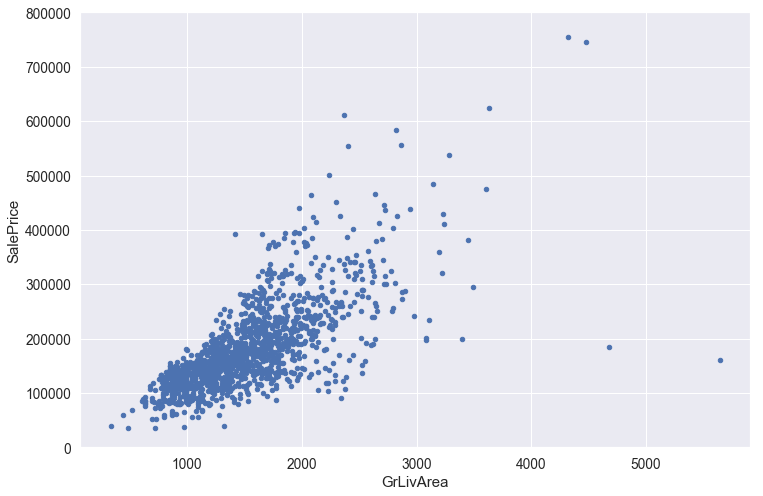

In [36]:
var = 'GrLivArea'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [37]:
# 从散点图中确定去除GrLivArea > 4000 且SalePrice < 200000的点
train_df = train_df.drop(train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 200000)].index)

### 创造性

删除相关性较弱的特征

In [38]:
train_df = train_df.drop(drop_columns, axis=1)
test_df = test_df.drop(drop_columns, axis=1)

In [39]:
print train_df.columns
print len(train_df.columns)
print test_df.columns

Index([u'MSSubClass', u'MSZoning', u'Street', u'Alley', u'LotShape',
       u'LandContour', u'Utilities', u'LotConfig', u'LandSlope',
       u'Neighborhood', u'Condition1', u'Condition2', u'BldgType',
       u'HouseStyle', u'OverallQual', u'OverallCond', u'YearBuilt',
       u'RoofStyle', u'RoofMatl', u'Exterior1st', u'Exterior2nd',
       u'MasVnrType', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinType2',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'GrLivArea',
       u'FullBath', u'BedroomAbvGr', u'KitchenQual', u'Functional',
       u'FireplaceQu', u'GarageType', u'GarageFinish', u'GarageCars',
       u'GarageQual', u'GarageCond', u'PavedDrive', u'PoolQC', u'Fence',
       u'MiscFeature', u'MoSold', u'YrSold', u'SaleType', u'SaleCondition',
       u'SalePrice', u'TotalSF'],
      dtype='object')
55
Index([u'MSSubClass', u'MSZoning', u'Street', u'Alley', u'LotShape',
       u'LandContour', u

### 倾斜数据处理

#### 预测值倾斜，对数处理

* <b> 偏度 </b>  正态分布的偏度为0。若数据分布是对称的，偏度 = 0。

     若偏度 > 0，分布为右偏，即分布有一条长尾在右；
     
     若偏度 < 0，分布为左偏，即分布有一条长尾在左。偏度的绝对值越大，说明分布的偏移程度越严重。


* <b> 峰度 </b>  正态分布的峰度为0。

    当峰度 > 0，它相比于正态分布要更陡峭或尾部更厚。
    
    峰度系数 < 0, 它相比于正态分布更平缓或尾部更薄。

Normality - When we talk about normality what we mean is that the data should look like a normal distribution. This is important because several statistic tests rely on this (e.g. t-statistics). In this exercise we'll just check univariate normality for 'SalePrice' (which is a limited approach). Remember that univariate normality doesn't ensure multivariate normality (which is what we would like to have), but it helps. Another detail to take into account is that in big samples (>200 observations) normality is not such an issue.

However, if we solve normality, we avoid a lot of other problems (e.g. heteroscedacity) so that's the main reason why we are doing this analysis.

正态分布

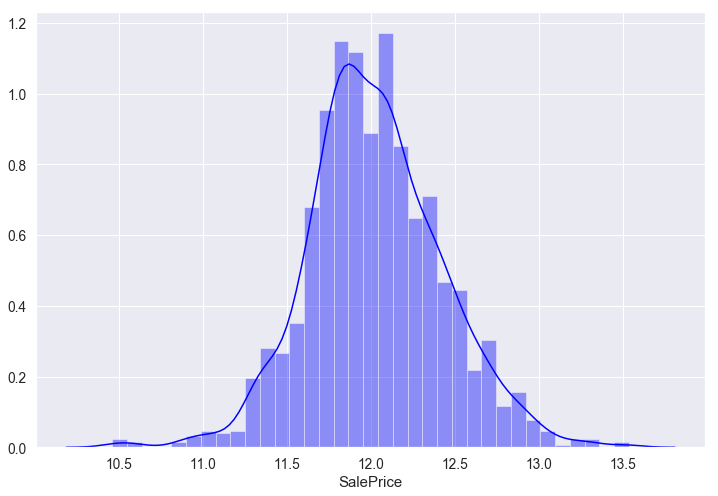

In [40]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])
sns.distplot(train_df['SalePrice'], color='blue')


In [41]:
print train_df['SalePrice'].skew()
train_df['SalePrice'].kurt()

0.121579760503


0.80475079174189723

#### 倾斜特征处理

倾斜特征

In [42]:
from scipy.stats import skew
numeric_features = train_df.dtypes[train_df.dtypes != "object"].index


skewed_features = train_df[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print "\nSkew in numerical features: \n"
skewness1 = pd.DataFrame({'Skew' :skewed_features})
print skewness1.head(10)


numeric_features = test_df.dtypes[test_df.dtypes != "object"].index


skewed_features = test_df[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print "\nSkew in numerical features: \n"
skewness2 = pd.DataFrame({'Skew' :skewed_features})
skewness2.head(10)


Skew in numerical features: 

                 Skew
GrLivArea    1.009951
TotalSF      0.803494
OverallQual  0.200579
SalePrice    0.121455
FullBath     0.031239
GarageCars  -0.342025
YearBuilt   -0.611665

Skew in numerical features: 



,Skew
TotalSF,1.206772
GrLivArea,1.129240
FullBath,0.295534
OverallQual,0.181010
GarageCars,-0.109880
YearBuilt,-0.587052


In [43]:
skewness = set(list(skewness1[abs(skewness1.values) > 0.75].index) + list(skewness2[abs(skewness2.values) > 0.75].
                                                                   index))

In [44]:
from scipy.special import boxcox1p
skewed_features = list(skewness)
lam = 0.15
for feature in skewed_features:
    #all_data[feat] += 1
    train_df[feature] = boxcox1p(train_df[feature], lam)
    test_df[feature] = boxcox1p(test_df[feature], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

### 转化性（类别数据）

In [45]:
features_train = train_df.drop(['SalePrice'], axis=1)
labels_train = train_df['SalePrice']
features_test = test_df

#### 直接独特编码，特征太多。独热+PCA效果不好

In [46]:
# features_train = pd.get_dummies(features_train)
# features_test = pd.get_dummies(test_df)

# missing_cols = set(features_train.columns) - set(features_test.columns)
# for column in missing_cols:
#     features_test[column] = 0
    
# # 保证测试集columns的顺序同训练集columns相同，特别重要！！！！！！
# features_test = features_test[features_train.columns]

In [47]:
# print len(features_train.columns), len(features_test.columns)
# print features_train

In [48]:
# # 数据标准化，避免量纲的影响（树模型不需要：树模型概率），注意测试训练集一起做
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# scaler = StandardScaler()
# features_train = scaler.fit_transform(features_train)
# features_test = scaler.fit_transform(features_test)


In [49]:
# pca = PCA(n_components=30)
# features_train = pca.fit_transform(features_train)
# features_test = pca.fit_transform(features_test)

# # 根据array新建一个DataFrame (二维数组， 列名)
# features_train = pd.DataFrame(features_train, columns = ['Dimension' + str(i) for i in range(1,31)])
# features_test = pd.DataFrame(features_test, columns = ['Dimension' + str(i) for i in range(1,31)])


In [50]:
# print features_train.head(10)

#### Label Encoding 一些可以包含信息的类别特征

**in their ordering set** 

In [51]:
from sklearn.preprocessing import LabelEncoder
# categories = [i for i in train_df.columns if i not in cols]
# process columns, apply LabelEncoder to categorical features

categories = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold', 'BedroomAbvGr']

for c in categories:
    lbl = LabelEncoder() 
    features_train[c] = lbl.fit_transform(list(features_train[c].values))
    features_test[c] = lbl.fit_transform(list(features_test[c].values))


# shape        
print 'Shape all_data: {}'.format(features_train.shape)
print 'Shape all_data: {}'.format(features_test.shape)


Shape all_data: (1458, 54)
Shape all_data: (1459, 54)


In [52]:
print [i for i in features_train.columns if (i not in categories) and (i not in cols) ]

['MSZoning', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition']


#### 处理Label Encoding转换后无高低顺序的特征 （同目标无相关性的特征）

In [53]:
# remove_columns = ['Exterior2nd']

In [54]:
# features_train = features_train.drop(remove_columns, axis=1)
# features_test = features_test.drop(remove_columns, axis=1)

In [55]:
# var = 'SaleCondition'  # 
# data = pd.concat([labels_train, train_df[var]], axis=1)
# f, ax = plt.subplots(figsize=(8, 6))
# fig = sns.boxplot(x=var, y="SalePrice", data=data)  # 横坐标类别，纵坐标目标变量
# fig.axis(ymin=0, ymax=800000);

#### 独热编码其他与顺序无关的特征

In [56]:
features_train = pd.get_dummies(features_train)
features_test = pd.get_dummies(test_df)

missing_cols = set(features_train.columns) - set(features_test.columns)
for column in missing_cols:
    features_test[column] = 0
    
# 保证测试集columns的顺序同训练集columns相同，特别重要！！！！！！
features_test = features_test[features_train.columns]

In [57]:
print len(features_train.columns)

196


PCA降维


### 分割训练和测试数据

In [58]:
from sklearn.model_selection import train_test_split

# 分割features_train 和 labels_train, 测试集大小 = 20%，状态：随机，可复现
# 顺序：测试特征，训练特征，测试目标，训练目标

X_train, X_test, y_train, y_test = train_test_split(features_train, labels_train, test_size = 0.2, random_state = 42)

# 输出数量观察

print len(X_train), len(X_test)

1166 292


# 模型

## 分析问题，确定模型

问题为回归问题，可用模型：线性回归，决策树（C&RT决策树），随机森林，GBDT

## 首先用简单的模型进行试验，观察评分

回归模型评分指标包括：

1、SSE误差平方和

2、R-square（决定系数）

3、矫正决定系数

In [59]:
# 导入算法模型和评分标准 
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import fbeta_score, make_scorer, r2_score ,mean_squared_error
from xgboost import XGBRegressor

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# 初始化,确定随机状态，可复现
reg1 = DecisionTreeRegressor(random_state = 42)
reg2 = LinearRegression()
reg3 = RandomForestRegressor(random_state = 42)
reg4 = XGBRegressor()


# 建立字典，收集学习器的效果
# 学习，收集预测得分
results = {}
for reg in [reg1, reg2, reg3, reg4]:
    # 回归器的名称
    reg_name = reg.__class__.__name__
    reg.fit(X_train, y_train)
    pred_test = reg.predict(X_test)
    results[reg_name] = rmse(y_test, pred_test)
    
print results

{'RandomForestRegressor': 0.15333531548337406, 'LinearRegression': 0.13495581158132186, 'XGBRegressor': 0.12181807442982734, 'DecisionTreeRegressor': 0.23054321884145609}


## 网格搜索调参

### 随机森林

In [60]:
# # 模型：RandomForest
# # 导入Grid
# from sklearn.model_selection import GridSearchCV

# # 初始化回归模型
# reg = RandomForestRegressor(random_state=42)

# # 确定参数列表
# parameters = {'min_samples_split':range(2,6), 'max_depth':range(10, 101, 10)}

# # 确定评分标准
# scorer = make_scorer(r2_score)

# # 回归模型使用网格搜索
# grid_reg = GridSearchCV(reg, parameters, scoring = scorer)

# # 训练
# grid_reg.fit(X_train, y_train)

# # 获得最佳拟合回归器
# best_reg = grid_reg.best_estimator_

### 线性回归

In [61]:
# # 模型：线性回归
# from sklearn.model_selection import GridSearchCV

# # 初始化回归模型
# reg = LinearRegression()

# # 确定参数列表
# parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

# # 确定评分标准
# scorer = make_scorer(r2_score)

# # 回归模型使用网格搜索
# grid_reg = GridSearchCV(reg, parameters, scoring = scorer)

# # 训练
# grid_reg.fit(X_train, y_train)

# # 获得最佳拟合回归器
# best_reg = grid_reg.best_estimator_

### Xgboost

In [62]:
# 模型：Xgboost
from sklearn.model_selection import GridSearchCV

# 初始化模型
reg = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             nthread = -1)

# 设定参数
# parameters = {
    
# }

# # 评分标准
# scorer = make_scorer(r2_score)

# # 网格搜索
# grid_reg = GridSearchCV(reg, parameters, scoring=scorer)

# 训练
reg.fit(X_train, y_train)

# 获取最佳拟合器
best_reg = reg

## 交叉验证

### 测试集上的分数

In [63]:
pred_y_test = best_reg.predict(X_test)
print rmse(pred_y_test, y_test)

# pred_y_train = best_reg.predict(X_train)
# print rmse(pred_y_train, y_train)

0.118329078343


### 学习曲线

使用Sklearn中学习曲线函数：http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

In [64]:
# print(__doc__)

# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# from sklearn.datasets import load_digits
# from sklearn.model_selection import learning_curve
# from sklearn.model_selection import ShuffleSplit


# def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
#                         n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
#     """
#     Generate a simple plot of the test and training learning curve.

#     Parameters
#     ----------
#     estimator : object type that implements the "fit" and "predict" methods
#         An object of that type which is cloned for each validation.

#     title : string
#         Title for the chart.

#     X : array-like, shape (n_samples, n_features)
#         Training vector, where n_samples is the number of samples and
#         n_features is the number of features.

#     y : array-like, shape (n_samples) or (n_samples, n_features), optional
#         Target relative to X for classification or regression;
#         None for unsupervised learning.

#     ylim : tuple, shape (ymin, ymax), optional
#         Defines minimum and maximum yvalues plotted.

#     cv : int, cross-validation generator or an iterable, optional
#         Determines the cross-validation splitting strategy.
#         Possible inputs for cv are:
#           - None, to use the default 3-fold cross-validation,
#           - integer, to specify the number of folds.
#           - An object to be used as a cross-validation generator.
#           - An iterable yielding train/test splits.

#         For integer/None inputs, if ``y`` is binary or multiclass,
#         :class:`StratifiedKFold` used. If the estimator is not a classifier
#         or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

#         Refer :ref:`User Guide <cross_validation>` for the various
#         cross-validators that can be used here.

#     n_jobs : integer, optional
#         Number of jobs to run in parallel (default 1).
#     """
#     plt.figure()
#     plt.title(title)
#     if ylim is not None:
#         plt.ylim(*ylim)
#     plt.xlabel("Training examples")
#     plt.ylabel("Score")
#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
#     plt.grid()

#     plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.1,
#                      color="r")
#     plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
#     plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
#              label="Training score")
#     plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
#              label="Cross-validation score")

#     plt.legend(loc="best")
#     return plt

In [65]:
# title = "Learning Curves (Xgboost)"
# # Cross validation with 100 iterations to get smoother mean test and train
# # score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

# estimator = XGBRegressor()
# plot_learning_curve(estimator, title, features_train, labels_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

# plt.show()

# 预测目标数据

In [66]:
pred = np.expm1(best_reg.predict(features_test))
pred

array([ 115549.734375,  153082.796875,  180765.5     , ...,  148156.5625  ,
        120176.015625,  224487.96875 ], dtype=float32)

# 输出结果

In [67]:
# 增加索引，列名，构建DataFrame，符合输出数据格式

test_df = pd.read_csv('test.csv')
predict_df = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': pred})

# DataFrame设定index
predict_df = predict_df.set_index('Id')

# 重命名DataFrame的列，列名 = 字典{原：替换后}
# predict_df.rename(columns = {predict_df.columns[0]: 'Id'}, inplace=True)

predict_df

,SalePrice
Id,
1461,115549.734375
1462,153082.796875
1463,180765.500000
1464,193087.359375
1465,198980.062500
1466,172979.484375
1467,176049.718750
1468,170636.625000
1469,186425.578125


In [68]:
predict_df.to_csv('Submission.csv')

# 待优化策略

ROUND 1：

I：PCA得分： 0.21683  RF

II：去掉PCA得分：0.18129，3227位  RF

III：Xgboost + 所有特征270: 0.14339 ⬆️（可解释性差，容易过拟合）

III：相关性强数值特征 ：0.14870 ⬇️

IV：相关性强数值特征 + Label Coder + 对数处理目标变量：0.14628 ⬇️

V: 一些数值特征转换为类别特征：Msubclass等：0.13902 ⬆️

VI：转化性中：一些类别特征Label coder有序，有意义：

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
       
       一些类别特征有序无隐含信息，直接独热编码
       
      0.13814 ⬆️
       
VII: 处理倾斜特征 0.13811 ⬆️
 
ROUND2：

I：类别特征 - 完整性，部分类别特征确实缺失数据  0.13806 ⬆️

II：XGboost 调参 0.12979 ✅



待优化点有：

1、评分标准更改为Kaggle标准 ✅

2、特征分析，创造新特征 ✅

特征较多：74，如何选取以及探索恰当的特征？

【客观分析】

3、探索性分析，确定关键特征 ✅

【探索性数据分析】

4、Xgboost学习，调参  ✅

5、集成方法 stacking

6、模型有些过拟合，试图减少特征的数量 ✅

7、对类别特征进行取舍，选取相关性强的类别特征


待解决问题有：

1、为什么使用PCA降维后效果不好？

2、怎么判断模型存在过拟合？✅

学习曲线，Learning curve

3、线性回归为什么有负值 ✅

在做类别数据 -> 数值转化时，训练集同测试集列名存在区别。只新增了测试集缺失的列，未调整列的顺序。
注意：test = test[train.columns]

4、XGboost调参技巧 ❌



In [69]:
df = pd.DataFrame(np.random.randint(1,10, size=(3,4)), columns = ['A', 'B', 'C', 'D'])

In [70]:
df2 = pd.DataFrame(np.random.randint(1,10, size=(2,3)), columns = ['A', 'C', 'D'])

In [71]:
df2

,A,C,D
0,3,6,7
1,2,1,7


In [72]:
df

,A,B,C,D
0,5,1,7,6
1,5,9,7,1
2,7,1,2,1


In [73]:
missing_cols = set(df.columns) - set(df2.columns)
for column in missing_cols:
    df2[column] = 0

In [74]:
df2

,A,C,D,B
0,3,6,7,0
1,2,1,7,0


In [75]:
df2 = df2[df.columns]

In [76]:
df2

,A,B,C,D
0,3,0,6,7
1,2,0,1,7
